In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from google.colab import auth
from google.auth import default
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
from google.colab import drive
drive.mount('/drive')

creds, _ = default()
gc = gspread.authorize(creds)

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [42]:
kb_claims_filepath = '/drive/MyDrive/DSN/politifact_filtered_noflips.csv' # for ground truth mapping
podcast_claims_filepath = '/drive/MyDrive/spotify-misinformation/preprocessing-output/podcast_claims_context_2_reupload.tsv' # for uri mapping

# utility functions to read data
claims_df = pd.read_csv(kb_claims_filepath)

def df_from_google_sheets(path, columns):

  """
  Get a pandas dataframe object from Google Sheets
  """

  worksheet = gc.open(path).sheet1
  rows = worksheet.get_all_values()
  rows = [x[:5] for x in rows]

  return pd.DataFrame.from_records(rows[1:], columns=columns)

def get_full_df(raw_claims_df, labeled_df):

  """
  Retrieve show/episode (URI) metadata from pairs that have been annotated

  raw_claims_df: Pandas df object - (larger) dataset containing unmatched claims
  labeled_df: Pandas df object - (smaller) dataset with annotated samples
  """

  raw_claims_df = raw_claims_df.reset_index()
  labeled_df = labeled_df.reset_index()
  raw_claims_df['Stance Agreement'] = -1 # Initialize all as unlabeled, get labels from annotations below

  tuples_list = []
  for i in range(0,len(labeled_df)):
    print(i)
    tuple_2d = (labeled_df['Podcast Claim Index'][i], labeled_df['Stance Agreement'][i])
    tuples_list.append(tuple_2d)

    podcast_idx = tuples_list[i][0]
    pair_stance = int(tuples_list[i][1])

    # Getting corresponding row
    row_idx = raw_claims_df[(raw_claims_df['Podcast Claim Index'] == podcast_idx)].index.tolist()
    #row_idx = int(podcast_idx)

    raw_claims_df['Stance Agreement'][row_idx] = pair_stance
  
  return raw_claims_df

# Importing Labeled Dataset

In [3]:
column_names = ['Fact Checked Claim Index', 'Podcast Claim Index', 'Fact Checked Claim', 'Podcast Claim', 'Stance Agreement']

december_labeled_data_path = '/drive/My Drive/spotify-misinformation/labeling-output/manually-labeled-matched-pairs.csv'
december_labeled_data = pd.read_csv(december_labeled_data_path)
omar_individual = df_from_google_sheets('top_3000_context_2_single_sentence_omar_individual', columns=column_names)
omar_individual_data = omar_individual[200:800].copy()
jon_individual = df_from_google_sheets('top_3000_context_2_single_sentence_jon_individual', columns=column_names)
jon_individual_data = jon_individual[200:800].copy()
omar_predictions_data = df_from_google_sheets('spotifact-predictions-labeling-omar', columns=column_names)
omar_predictions_data_2 = df_from_google_sheets('spotifact-predictions-labeling-omar-2', columns=column_names)
omar_predictions_data_3 = df_from_google_sheets('spotifact-predictions-labeling-omar-3', columns=column_names)
omar_predictions_data_retrain = df_from_google_sheets('spotifact-predictions-labeling-omar-retrain', columns=column_names)
omar_predictions_partials = df_from_google_sheets('spotifact-predictions-labeling-omar-partials-3k-13k', columns=column_names)

frames = [december_labeled_data, omar_individual_data, jon_individual_data, omar_predictions_data, 
          omar_predictions_data_2, omar_predictions_data_retrain, omar_predictions_partials]

total_labeled_data = pd.concat(frames) # Concatenated df with overlap and recent Jon (Omar) and Omar's 2022 labels
total_labeled_data[['Stance Agreement']] = total_labeled_data[['Stance Agreement']].astype('int')
total_labeled_data = total_labeled_data.drop(total_labeled_data[total_labeled_data['Stance Agreement']==-1].index)
total_labeled_data['Stance Agreement'].value_counts()

5    1987
2     499
1     220
6     159
3     151
4      89
Name: Stance Agreement, dtype: int64

# Misinformation Analysis

In [4]:
politifact_df = pd.read_csv(kb_claims_filepath)
politifact_df['Fact Checked Claim Index'] = np.arange(len(politifact_df))
politifact_df.loc[politifact_df['Label'] == 'true', 'Numeric Label'] = 1
politifact_df.loc[politifact_df['Label'] == 'mostly-true', 'Numeric Label'] = 2
politifact_df.loc[politifact_df['Label'] == 'half-true', 'Numeric Label'] = 3
politifact_df.loc[politifact_df['Label'] == 'barely-true', 'Numeric Label'] = 4
politifact_df.loc[politifact_df['Label'] == 'mostly-false', 'Numeric Label'] = 5
politifact_df.loc[politifact_df['Label'] == 'false', 'Numeric Label'] = 6
politifact_df.loc[politifact_df['Label'] == 'pants-fire', 'Numeric Label'] = 7
politifact_df[['Numeric Label']] = politifact_df[['Numeric Label']].astype('int')
total_labeled_data[['Stance Agreement']] = total_labeled_data[['Stance Agreement']].astype('int')

# Loop over labeled data
numeric_labels_list = []
for index, row in total_labeled_data.iterrows():

   politifact_id = int(row['Fact Checked Claim Index'])
   stance_agreement = int(row['Stance Agreement'])
   claim_label = politifact_df.at[politifact_df['Fact Checked Claim Index'].eq(politifact_id).idxmax(), 'Numeric Label']
   numeric_labels_list.append(claim_label)
  
   #print(politifact_id, stance_agreement, claim_label, index)

total_labeled_data['Numeric Label'] = numeric_labels_list

# Create a list of our conditions

true_conditions = [
    ((total_labeled_data['Numeric Label'] == 1) & (total_labeled_data['Stance Agreement'] == 1)),
    ((total_labeled_data['Numeric Label'] == 1) & (total_labeled_data['Stance Agreement'] == 2)),
    ((total_labeled_data['Numeric Label'] == 1) & (total_labeled_data['Stance Agreement'] == 3)),
    ((total_labeled_data['Numeric Label'] == 1) & (total_labeled_data['Stance Agreement'] == 4)),
    ((total_labeled_data['Numeric Label'] == 1) & (total_labeled_data['Stance Agreement'] == 5)),
    ((total_labeled_data['Numeric Label'] == 1) & (total_labeled_data['Stance Agreement'] == 6)),
    ]

mostly_true_conditions = [
    ((total_labeled_data['Numeric Label'] == 2) & (total_labeled_data['Stance Agreement'] == 1)),
    ((total_labeled_data['Numeric Label'] == 2) & (total_labeled_data['Stance Agreement'] == 2)),
    ((total_labeled_data['Numeric Label'] == 2) & (total_labeled_data['Stance Agreement'] == 3)),
    ((total_labeled_data['Numeric Label'] == 2) & (total_labeled_data['Stance Agreement'] == 4)),
    ((total_labeled_data['Numeric Label'] == 2) & (total_labeled_data['Stance Agreement'] == 5)),
    ((total_labeled_data['Numeric Label'] == 2) & (total_labeled_data['Stance Agreement'] == 6)),
    ]

half_true_conditions = [
    ((total_labeled_data['Numeric Label'] == 3) & (total_labeled_data['Stance Agreement'] == 1)),
    ((total_labeled_data['Numeric Label'] == 3) & (total_labeled_data['Stance Agreement'] == 2)),
    ((total_labeled_data['Numeric Label'] == 3) & (total_labeled_data['Stance Agreement'] == 3)),
    ((total_labeled_data['Numeric Label'] == 3) & (total_labeled_data['Stance Agreement'] == 4)),
    ((total_labeled_data['Numeric Label'] == 3) & (total_labeled_data['Stance Agreement'] == 5)),
    ((total_labeled_data['Numeric Label'] == 3) & (total_labeled_data['Stance Agreement'] == 6)),
    ]

barely_true_conditions = [
    ((total_labeled_data['Numeric Label'] == 4) & (total_labeled_data['Stance Agreement'] == 1)),
    ((total_labeled_data['Numeric Label'] == 4) & (total_labeled_data['Stance Agreement'] == 2)),
    ((total_labeled_data['Numeric Label'] == 4) & (total_labeled_data['Stance Agreement'] == 3)),
    ((total_labeled_data['Numeric Label'] == 4) & (total_labeled_data['Stance Agreement'] == 4)),
    ((total_labeled_data['Numeric Label'] == 4) & (total_labeled_data['Stance Agreement'] == 5)),
    ((total_labeled_data['Numeric Label'] == 4) & (total_labeled_data['Stance Agreement'] == 6)),
    ]

mostly_false_conditions = [
    ((total_labeled_data['Numeric Label'] == 5) & (total_labeled_data['Stance Agreement'] == 1)),
    ((total_labeled_data['Numeric Label'] == 5) & (total_labeled_data['Stance Agreement'] == 2)),
    ((total_labeled_data['Numeric Label'] == 5) & (total_labeled_data['Stance Agreement'] == 3)),
    ((total_labeled_data['Numeric Label'] == 5) & (total_labeled_data['Stance Agreement'] == 4)),
    ((total_labeled_data['Numeric Label'] == 5) & (total_labeled_data['Stance Agreement'] == 5)),
    ((total_labeled_data['Numeric Label'] == 5) & (total_labeled_data['Stance Agreement'] == 6)),
    ]

false_conditions = [
    ((total_labeled_data['Numeric Label'] == 6) & (total_labeled_data['Stance Agreement'] == 1)),
    ((total_labeled_data['Numeric Label'] == 6) & (total_labeled_data['Stance Agreement'] == 2)),
    ((total_labeled_data['Numeric Label'] == 6) & (total_labeled_data['Stance Agreement'] == 3)),
    ((total_labeled_data['Numeric Label'] == 6) & (total_labeled_data['Stance Agreement'] == 4)),
    ((total_labeled_data['Numeric Label'] == 6) & (total_labeled_data['Stance Agreement'] == 5)),
    ((total_labeled_data['Numeric Label'] == 6) & (total_labeled_data['Stance Agreement'] == 6)),
    ]

pants_fire_conditions = [
    ((total_labeled_data['Numeric Label'] == 7) & (total_labeled_data['Stance Agreement'] == 1)),
    ((total_labeled_data['Numeric Label'] == 7) & (total_labeled_data['Stance Agreement'] == 2)),
    ((total_labeled_data['Numeric Label'] == 7) & (total_labeled_data['Stance Agreement'] == 3)),
    ((total_labeled_data['Numeric Label'] == 7) & (total_labeled_data['Stance Agreement'] == 4)),
    ((total_labeled_data['Numeric Label'] == 7) & (total_labeled_data['Stance Agreement'] == 5)),
    ((total_labeled_data['Numeric Label'] == 7) & (total_labeled_data['Stance Agreement'] == 6)),
    ]

# Add lists for final condition
conditions = true_conditions + mostly_true_conditions + half_true_conditions + barely_true_conditions + mostly_false_conditions + false_conditions + pants_fire_conditions

#Create a list of the values we want to assign for each condition
true_mapping = ['True', 'Potentially True', 'Misinformation', 
                'Potential Misinformation', 'Unrelated', 'Inconclusive']
mostly_true_mapping = ['True', 'Potentially True', 'Misinformation', 
                       'Potential Misinformation', 'Unrelated', 'Inconclusive']
# HALF-TRUE LABELS ARE TRICKY 
half_true_mapping = ['Misinformation', 'Potential Misinformation', 'Potential Misinformation', 
                      'Potential Misinformation', 'Unrelated', 'Inconclusive']
# Barely true and mostly false can be the same
barely_true_mapping = ['Misinformation', 'Potential Misinformation', 'True', 
                      'Potentially True', 'Unrelated', 'Inconclusive']                     
mostly_false_mapping = ['Misinformation', 'Potential Misinformation', 'True', 
                      'Potentially True', 'Unrelated', 'Inconclusive']
false_mapping = ['Misinformation', 'Potential Misinformation', 'True', 
                 'Potentially True', 'Unrelated', 'Inconclusive']
pants_fire_mapping = ['Misinformation', 'Potential Misinformation', 'True', 
                 'Potentially True', 'Unrelated', 'Inconclusive']

# Add lists for final mapping
mappings = true_mapping + mostly_true_mapping + half_true_mapping + barely_true_mapping + mostly_false_mapping + false_mapping + pants_fire_mapping

# Create a new column and use np.select to assign values to it using our lists as arguments
total_labeled_data['Misinformation Label'] = np.select(conditions, mappings)
misinfo_df = total_labeled_data.loc[total_labeled_data['Misinformation Label'] == 'Misinformation']
total_labeled_data['Misinformation Label'].value_counts()

Unrelated                   1987
Potential Misinformation     327
Potentially True             268
True                         204
Misinformation               160
Inconclusive                 159
Name: Misinformation Label, dtype: int64

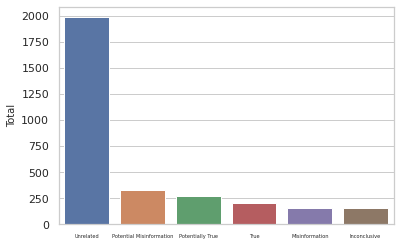

In [5]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(x=total_labeled_data['Misinformation Label'].value_counts().index, y=total_labeled_data['Misinformation Label'].value_counts())
ax.set_xticklabels(ax.get_xticklabels(), fontsize=5)
ax.set_ylabel("Total", fontsize = 10)

fig = ax.get_figure()
fig.savefig('/drive/My Drive/misinformation-barplot-2022.png', dpi=500)

# Matching labeled data to Metadata (URIs)

In [6]:
raw_claims_df = pd.read_csv('/drive/My Drive/raw-claims-uris.csv')
raw_claims_df = raw_claims_df.drop(['Unnamed: 0'], axis=1)
raw_claims_df[['Podcast Claim Index']] = raw_claims_df[['Podcast Claim Index']].astype('object')

In [7]:
agreement_df = total_labeled_data.loc[total_labeled_data['Stance Agreement'] == 1]
partial_agreement_df = total_labeled_data.loc[total_labeled_data['Stance Agreement'] == 2]
disagreement_df = total_labeled_data.loc[total_labeled_data['Stance Agreement'] == 3]
partial_disagreement_df = total_labeled_data.loc[total_labeled_data['Stance Agreement'] == 4]
total_relev_df = pd.concat([agreement_df,partial_agreement_df,disagreement_df,partial_disagreement_df])

In [ ]:
full_df_uris = get_full_df(raw_claims_df, misinfo_df)

In [19]:
full_uris_relev_df = full_df_uris.drop(full_df_uris[full_df_uris['Stance Agreement']==-1].index)
#full_uris_relev_df['Show URI'].value_counts()

In [ ]:
full_uris_relev_df['Show URI'].value_counts()

In [21]:
full_uris_relev_df['Stance Agreement'].value_counts()

1    45
3     1
Name: Stance Agreement, dtype: int64

# Misinformation Per Podcast

###### This notebook is a bit RAM intensive so to not read the metadata file (which is also large) I simply looked up the Podcast show names with the URI in the metadata

In [22]:
full_uris_relev_df.loc[full_uris_relev_df['Show URI'] == 'show_2FqT7bkuLecryBNkApjABK']

,index,Show URI,Episode URI,Claim,Podcast Claim Index,Stance Agreement
10020231,10020231,show_2FqT7bkuLecryBNkApjABK,6Yyk708JYzmIYpyDDIZbP9,"When I say well, why would you think that he ...",10020231,1
10020306,10020306,show_2FqT7bkuLecryBNkApjABK,6Yyk708JYzmIYpyDDIZbP9,It could have been created like that. That's ...,10020306,1


In [26]:
misinfo_df.loc[misinfo_df['Podcast Claim Index'] == 5968532]

,Fact Checked Claim Index,Podcast Claim Index,Fact Checked Claim,Podcast Claim,Stance Agreement,Numeric Label,Misinformation Label
990,4330,5968532,"""In America today, women on average are paid 8...",We've been talking about this and talking abo...,1,4,Misinformation


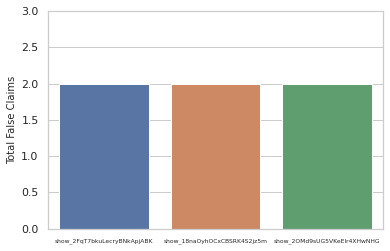

In [38]:
sns.set_theme(style="whitegrid")
uris_count = full_uris_relev_df['Show URI'].value_counts()
ax = sns.barplot(x=uris_count[uris_count>1][0:5].index, y=uris_count[uris_count>1][0:5])
ax.set_xticklabels(ax.get_xticklabels(), fontsize=6)
ax.set_ylabel("Total False Claims", fontsize = 10)
plt.ylim(0, 3)

fig = ax.get_figure()
fig.savefig('/drive/My Drive/misinformation-pp-barplot-2022.png', dpi=500)